# CoDA — v2-plus (working splits + all extras)
This notebook **preserves your v2 behavior** (splits + deterministic transitions) and adds:
- a clear **cfg** block,
- **30-seed** metrics with mean±SE (KL/JS/Entropy/Markovization),
- **analytic ground-truth** (acq: clones, ext: no clones),
- **no-reset extinction** with wash-in and structural merge,
- **final learned vs GT** plots and **change-aware snapshots** for a chosen seed.


In [1]:

import numpy as np, matplotlib.pyplot as plt
from typing import List
from spatial_environments import GridEnvRightDownNoSelf, GridEnvRightDownNoCue
from util import generate_dataset, generate_dataset_post_augmentation
from coda_trial_by_trial_util import CoDAAgent, CoDAConfig, normalize_transition_counts


## Config (edit here)

In [2]:

# Seeds & episodes
N_SEEDS   = 30
SEED0     = 0
N_ACQ     = 250
N_EXT     = 300
MAX_STEPS = 20
CUE       = 5

# Extinction wash-in (no reset): early stronger forgetting + decisive merges
WASH_IN = 50
EDGE_EPS_EARLY = 1e-4
EDGE_EPS_LATE  = 1e-6

# Which seed to visualize for maps & change-aware snapshots
PLOT_SEED = 7

# v2-style CoDA config (ACQUISITION = no decay)
cfg = CoDAConfig(
    gamma=0.95, lam=0.90,
    theta_split=0.90, theta_merge=0.50,
    confidence=0.90,
    n_threshold=8,
    min_presence_episodes=6,
    min_effective_exposure=15.0,
    count_decay=1.0,  # <- no forgetting in acquisition
    trace_decay=1.0,
    retro_decay=1.0
)


## Helpers: policy, absorbing, analytic ground-truth

In [3]:

def greedy_right_down_policy(env, s, acts):
    return 0 if 0 in acts else (1 if 1 in acts else np.random.choice(acts))

def run_episode_with_policy(env, policy_fn, max_steps=20):
    states, actions = [], []
    s = env.reset()
    for _ in range(max_steps):
        states.append(s)
        valid = env.get_valid_actions(s if s not in getattr(env, "clone_dict", {}) else env.clone_dict[s])
        if not valid: break
        a = policy_fn(env, s, valid); actions.append(a)
        s_next, r, done = env.step(a); s = s_next
        if done: states.append(s); break
    return states, actions

def absorb_terminals_in_learner(agent):
    for t in (agent.env.rewarded_terminals + agent.env.unrewarded_terminals):
        if t < agent.transition_counts.shape[0]:
            agent.transition_counts[t, :, :] = 0.0
    agent.transition_probs = normalize_transition_counts(agent.transition_counts)

# ---------- Analytic ground-truth ----------
def base_T_from_env(env):
    S = env.num_unique_states
    A = max(a for acts in env.valid_actions.values() for a in acts) + 1
    T = np.zeros((S, A, S), dtype=float)
    for s, acts in env.valid_actions.items():
        for a in acts:
            i,j = env.state_to_pos[s]; di,dj = env.base_actions[a]; ni,nj = i+di, j+dj
            sp = env.pos_to_state[(ni,nj)]; T[s,a,sp] = 1.0
    # terminals absorbing
    for t in (env.rewarded_terminals + env.unrewarded_terminals):
        if t < S: T[t,:,:] = 0.0
    return T

def gt_acquisition_with_clones(env, cue_states):
    T = base_T_from_env(env); S,A,_ = T.shape; clone_map = {}
    for cue in cue_states:
        for a in env.get_valid_actions(cue):
            i,j = env.state_to_pos[cue]; di,dj = env.base_actions[a]; ni,nj = i+di, j+dj
            sp = env.pos_to_state[(ni,nj)]
            if sp in clone_map: clone_id = clone_map[sp]
            else:
                clone_id = S; S += 1
                T = np.pad(T, ((0,1),(0,0),(0,1)), mode='constant')
                T[clone_id, :, :T.shape[2]-1] = T[sp, :, :T.shape[2]-1]
                clone_map[sp] = clone_id
            mass = T[cue, a, sp]; T[cue, a, sp] = 0.0; T[cue, a, clone_id] = mass
    return T

def gt_extinction_no_clones(env2):
    T = base_T_from_env(env2); S,A,_ = T.shape
    for idx, rt in enumerate(env2.rewarded_terminals):
        if idx < len(env2.unrewarded_terminals):
            nt = env2.unrewarded_terminals[idx]
            mask = T[:,:,rt] > 0; T[:,:,nt][mask] = T[:,:,rt][mask]; T[:,:,rt][mask] = 0.0
    return T


## Metrics (analytic GT; mean±SE)

In [4]:

EPS = 1e-12
def _safe_row_norm(x, axis=-1, eps=EPS):
    y = x.astype(float, copy=True); s=y.sum(axis=axis, keepdims=True); s[s<eps]=1.0; y/=s; return y
def _pad3(A, shape):
    S,A_,S2=A.shape; Sg,Ag,S2g=shape; out=np.zeros(shape); out[:min(S,Sg),:min(A_,Ag),:min(S2,S2g)] = A[:min(S,Sg),:min(A_,Ag),:min(S2,S2g)]; return out
def _agg(T): return _safe_row_norm(T.sum(axis=1), axis=1)
def _kl(p,q): p=np.clip(p,EPS,1.0);q=np.clip(q,EPS,1.0);p/=p.sum();q/=q.sum();return float(np.sum(p*(np.log(p)-np.log(q))))
def _js(p,q): p=np.clip(p,EPS,1.0);q=np.clip(q,EPS,1.0);p/=p.sum();q/=q.sum();m=0.5*(p+q);return 0.5*_kl(p,m)+0.5*_kl(q,m)
def _H(p): p=np.clip(p,EPS,1.0);p/=p.sum();return float(-np.sum(p*np.log(p)))
def kl_over_time_fixed(T_series, T_ref, use_js=False):
    scores=[]; shape=T_ref.shape
    for T in T_series:
        P,Q=_agg(_pad3(T,shape)),_agg(T_ref)
        scores.append(float(np.mean([_js(P[i],Q[i]) if use_js else _kl(P[i],Q[i]) for i in range(P.shape[0])])))
    return np.array(scores)
def entropy_over_time(T_series): return np.array([float(np.mean([_H(_agg(T)[i]) for i in range(_agg(T).shape[0])])) for T in T_series])
def markovization_score(T): P=_agg(T); H=np.array([_H(P[i]) for i in range(P.shape[0])]); Hmax=np.log(max(2,P.shape[1])); return float(1.0 - np.mean(H)/Hmax)
def mean_se(arrs):
    L=max(len(a) for a in arrs); M=np.full((len(arrs),L),np.nan)
    for i,a in enumerate(arrs): M[i,:len(a)]=a
    mean=np.nanmean(M,axis=0); se=np.nanstd(M,axis=0,ddof=max(1,min(len(arrs)-1,1)))/np.sqrt(max(1,len(arrs))); return mean,se
def plot_band(y_runs,title,ylabel):
    mean,se=mean_se(y_runs); x=np.arange(len(mean)); plt.figure(figsize=(10,4)); plt.plot(x,mean,lw=2.2,label=f"mean ({len(y_runs)} seeds)")
    plt.fill_between(x,mean-se,mean+se,alpha=0.25,label="±1 SE"); plt.title(title); plt.xlabel("Episode"); plt.ylabel(ylabel); plt.legend(); plt.grid(alpha=0.2); plt.show()


## Single-seed run (v2 acquisition; no-reset extinction)

In [5]:

def run_one_seed(seed:int, cfg:CoDAConfig):
    np.random.seed(seed)

    # Acquisition
    env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    agent = CoDAAgent(env, cfg)
    T_series_acq=[]; with_clones=False; first_split=False
    for ep in range(1, N_ACQ+1):
        if first_split:
            states, actions = run_episode_with_policy(env, greedy_right_down_policy, max_steps=MAX_STEPS)
        else:
            if with_clones:
                (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
            else:
                (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions); absorb_terminals_in_learner(agent)
        if agent.maybe_split(): with_clones=True; first_split=True
        T_series_acq.append(agent.get_T().copy())

    # Extinction (no reset; wash-in)
    env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    env2.clone_dict = dict(getattr(env, "clone_dict", {})); env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
    agent.env = env2
    orig = dict(count_decay=agent.cfg.count_decay, trace_decay=agent.cfg.trace_decay, retro_decay=agent.cfg.retro_decay,
                theta_merge=agent.cfg.theta_merge, confidence=agent.cfg.confidence,
                min_presence_episodes=agent.cfg.min_presence_episodes, min_effective_exposure=agent.cfg.min_effective_exposure)
    agent.cfg.count_decay=0.98; agent.cfg.trace_decay=0.98; agent.cfg.retro_decay=0.98
    agent.cfg.theta_merge=0.60; agent.cfg.confidence=0.99
    agent.cfg.min_presence_episodes += 3; agent.cfg.min_effective_exposure = int(agent.cfg.min_effective_exposure*1.5)

    T_series_ext=[]
    for k, ep in enumerate(range(N_ACQ+1, N_ACQ+N_EXT+1)):
        (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        agent._edge_eps_override = EDGE_EPS_EARLY if k < WASH_IN else EDGE_EPS_LATE
        agent.maybe_merge()
        T_series_ext.append(agent.get_T().copy())
        if k == WASH_IN-1:
            agent.cfg.count_decay=orig["count_decay"]; agent.cfg.trace_decay=orig["trace_decay"]; agent.cfg.retro_decay=orig["retro_decay"]
            agent.cfg.theta_merge=orig["theta_merge"]; agent.cfg.confidence=orig["confidence"]
            agent.cfg.min_presence_episodes=orig["min_presence_episodes"]; agent.cfg.min_effective_exposure=orig["min_effective_exposure"]

    # Analytic GTs
    T_ref_acq = gt_acquisition_with_clones(env, cue_states=[CUE])
    T_ref_ext = gt_extinction_no_clones(env2)

    # Metrics
    KL_acq = kl_over_time_fixed(T_series_acq, T_ref_acq, use_js=False)
    JS_acq = kl_over_time_fixed(T_series_acq, T_ref_acq, use_js=True)
    H_acq  = entropy_over_time(T_series_acq)
    MS_acq = np.array([markovization_score(T) for T in T_series_acq])

    KL_ext = kl_over_time_fixed(T_series_ext, T_ref_ext, use_js=False)
    JS_ext = kl_over_time_fixed(T_series_ext, T_ref_ext, use_js=True)
    H_ext  = entropy_over_time(T_series_ext)
    MS_ext = np.array([markovization_score(T) for T in T_series_ext])

    return dict(env_acq=env, env_ext=env2,
                T_series_acq=T_series_acq, T_series_ext=T_series_ext,
                T_ref_acq=T_ref_acq, T_ref_ext=T_ref_ext,
                KL_acq=KL_acq, JS_acq=JS_acq, H_acq=H_acq, MS_acq=MS_acq,
                KL_ext=KL_ext, JS_ext=JS_ext, H_ext=H_ext, MS_ext=MS_ext)


## Run 30 seeds & plot mean±SE bands

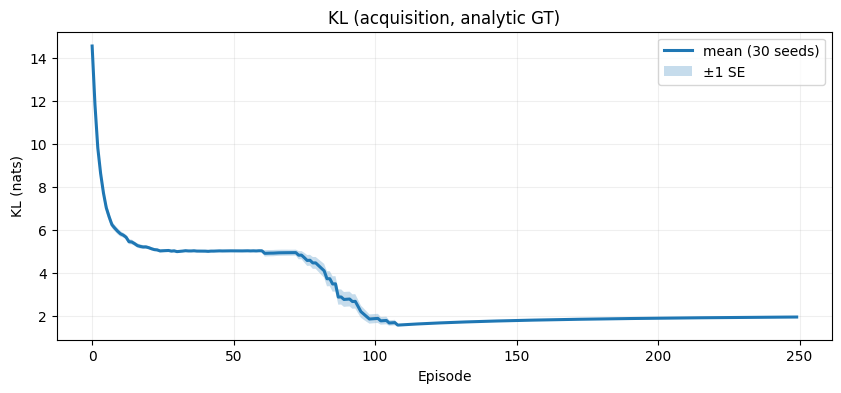

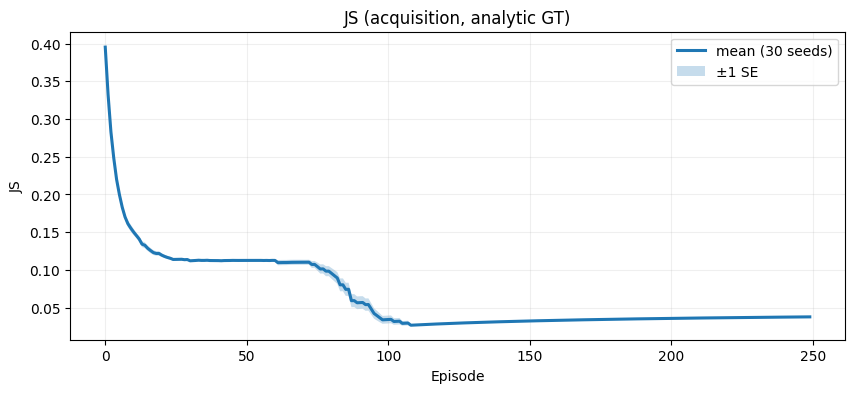

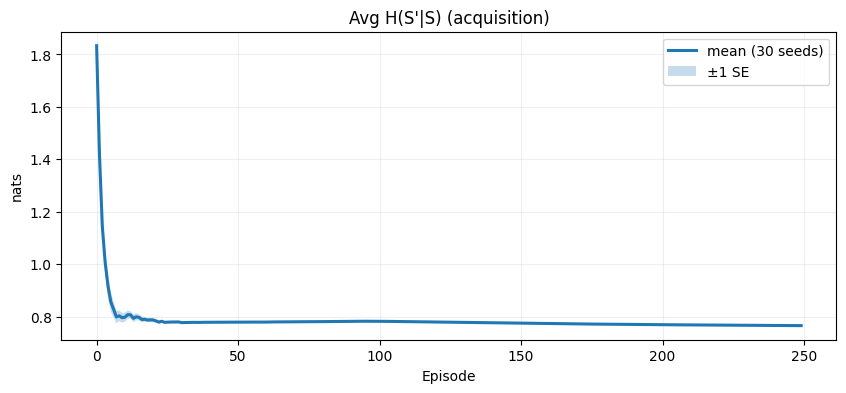

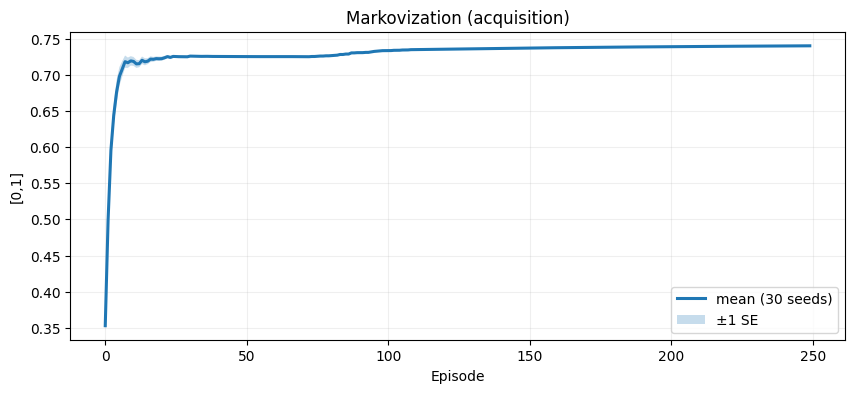

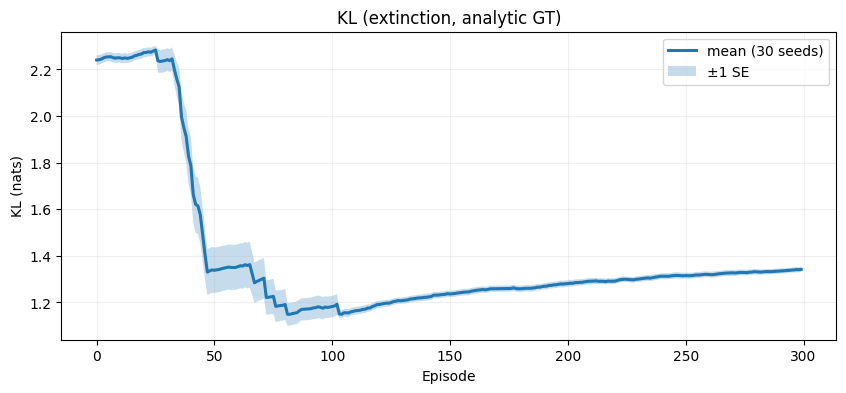

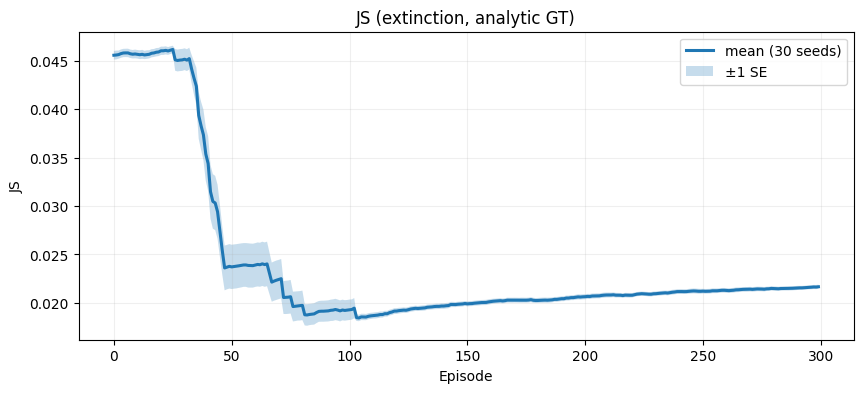

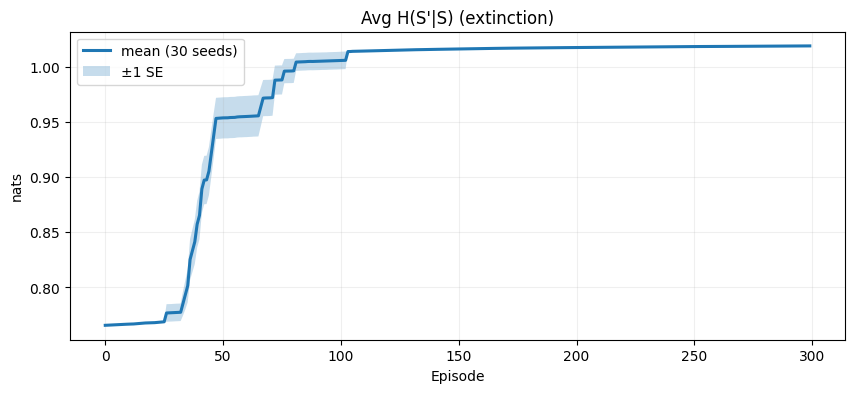

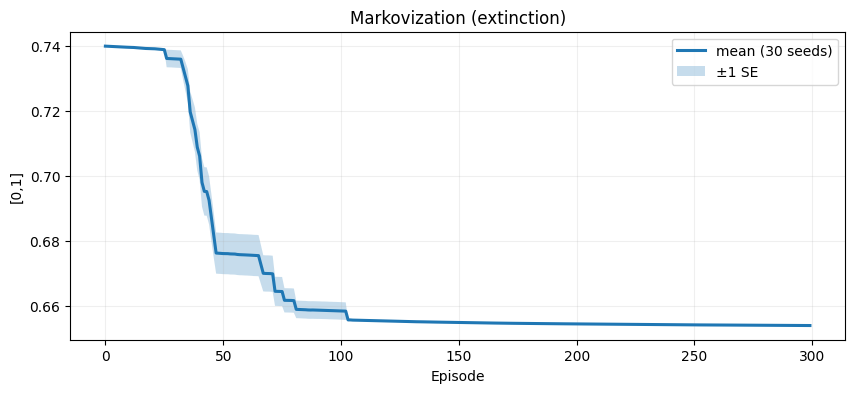

In [6]:

results = [run_one_seed(SEED0 + k, cfg) for k in range(N_SEEDS)]
KL_acq_runs=[r["KL_acq"] for r in results]; JS_acq_runs=[r["JS_acq"] for r in results]; H_acq_runs=[r["H_acq"] for r in results]; MS_acq_runs=[r["MS_acq"] for r in results]
KL_ext_runs=[r["KL_ext"] for r in results]; JS_ext_runs=[r["JS_ext"] for r in results]; H_ext_runs=[r["H_ext"] for r in results]; MS_ext_runs=[r["MS_ext"] for r in results]

plot_band(KL_acq_runs, "KL (acquisition, analytic GT)", "KL (nats)")
plot_band(JS_acq_runs, "JS (acquisition, analytic GT)", "JS")
plot_band(H_acq_runs,  "Avg H(S'|S) (acquisition)", "nats")
plot_band(MS_acq_runs, "Markovization (acquisition)", "[0,1]")
plot_band(KL_ext_runs, "KL (extinction, analytic GT)", "KL (nats)")
plot_band(JS_ext_runs, "JS (extinction, analytic GT)", "JS")
plot_band(H_ext_runs,  "Avg H(S'|S) (extinction)", "nats")
plot_band(MS_ext_runs, "Markovization (extinction)", "[0,1]")


## Final learned vs analytic GT (with arrows) for PLOT_SEED

Seed 7 — final learned (acquisition)


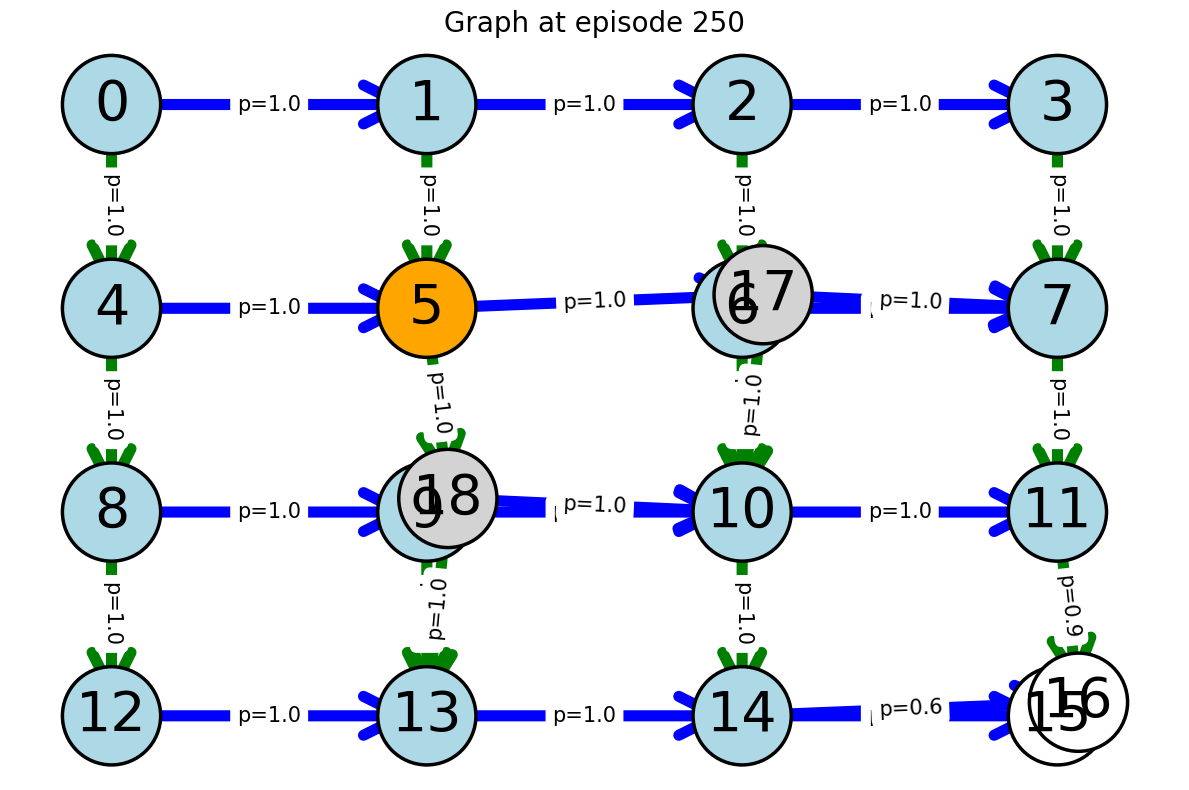

Ground-truth (acquisition; Markovian with clones)


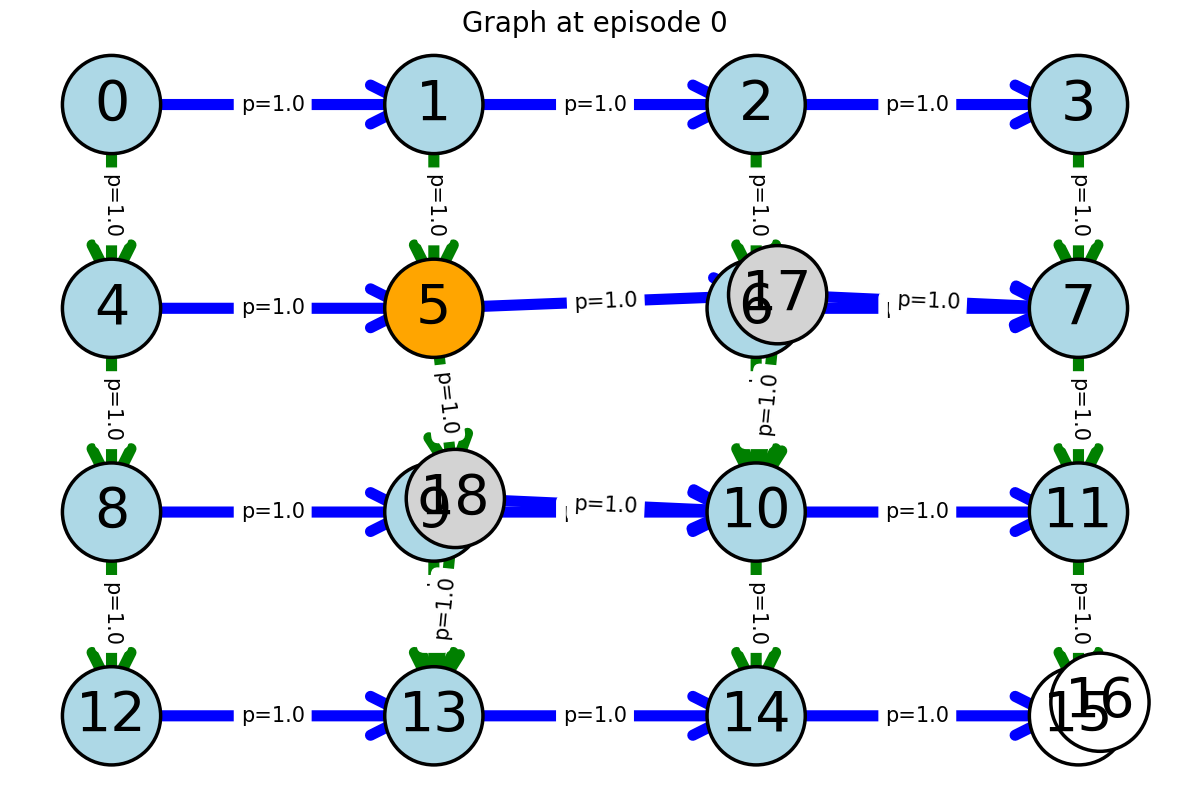

Seed 7 — final learned (extinction)


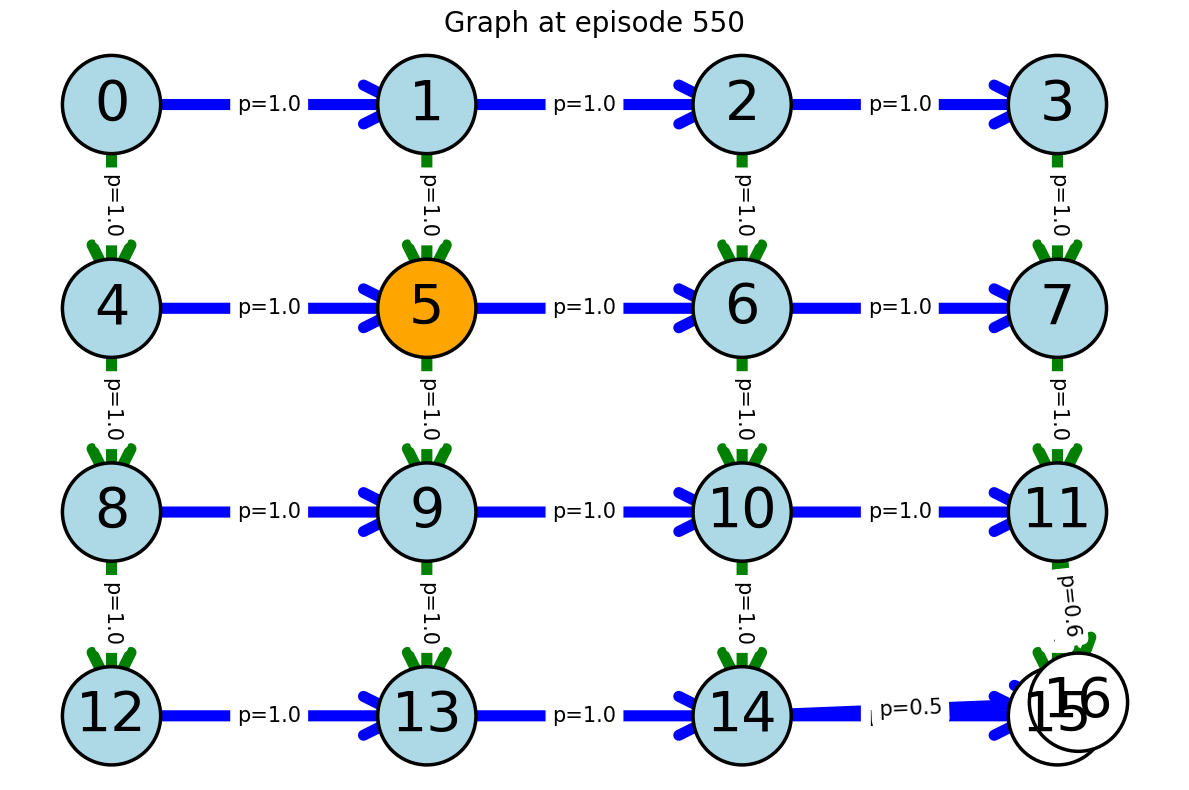

Ground-truth (extinction; no clones, deterministic)


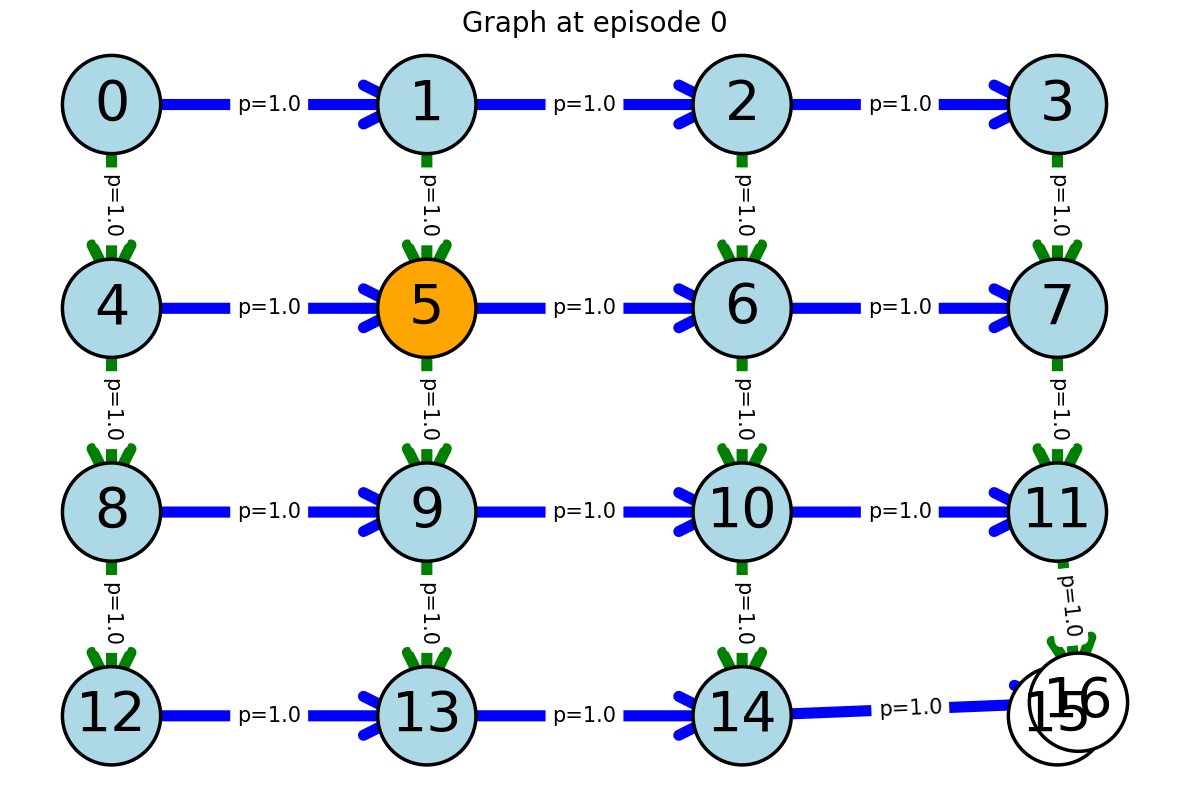

In [7]:

idx = PLOT_SEED - SEED0 if SEED0 <= PLOT_SEED < SEED0 + N_SEEDS else 0
env_acq = results[idx]["env_acq"]; env_ext = results[idx]["env_ext"]
T_acq_final = results[idx]["T_series_acq"][-1].copy(); T_ext_final = results[idx]["T_series_ext"][-1].copy()
T_ref_acq = results[idx]["T_ref_acq"]; T_ref_ext = results[idx]["T_ref_ext"]

def _pad3(A, shape):
    S,A_,S2=A.shape; Sg,Ag,S2g=shape; out=np.zeros(shape); out[:min(S,Sg),:min(A_,Ag),:min(S2,S2g)]=A[:min(S,Sg),:min(A_,Ag),:min(S2,S2g)]; return out
def make_terminals_absorbing_for_plot(T, terminals):
    T=T.copy()
    for t in terminals:
        if t < T.shape[0]: T[t,:,:]=0.0
    return T
def sanitize_for_plot(env, T, eps=1e-12):
    if T is None or getattr(T,"ndim",0)!=3: return
    S=T.shape[0]; out=T.sum(axis=(1,2)); inn=T.sum(axis=(0,1)); active=(out+inn)>eps
    for cl in list(getattr(env,"clone_dict",{}).keys()):
        if cl>=S or not active[cl]: env.clone_dict.pop(cl,None)
    env.reverse_clone_dict={parent:cl for cl,parent in env.clone_dict.items()}

shape1 = tuple(max(x,y) for x,y in zip(T_acq_final.shape, T_ref_acq.shape))
shape2 = tuple(max(x,y) for x,y in zip(T_ext_final.shape, T_ref_ext.shape))

T_acq_vis   = make_terminals_absorbing_for_plot(_pad3(T_acq_final, shape1), env_acq.rewarded_terminals + env_acq.unrewarded_terminals)
T_acq_gtvis = make_terminals_absorbing_for_plot(_pad3(T_ref_acq,   shape1), env_acq.rewarded_terminals + env_acq.unrewarded_terminals)
T_ext_vis   = make_terminals_absorbing_for_plot(_pad3(T_ext_final, shape2), env_ext.rewarded_terminals + env_ext.unrewarded_terminals)
T_ext_gtvis = make_terminals_absorbing_for_plot(_pad3(T_ref_ext,   shape2), env_ext.rewarded_terminals + env_ext.unrewarded_terminals)

sanitize_for_plot(env_acq, T_acq_vis); sanitize_for_plot(env_ext, T_ext_vis)
THRESH=0.30
print(f"Seed {PLOT_SEED} — final learned (acquisition)"); env_acq.plot_graph(T_acq_vis, niter=N_ACQ, threshold=THRESH, save=False, savename=f"acq_learned_seed{PLOT_SEED}.png")
print("Ground-truth (acquisition; Markovian with clones)"); env_acq.plot_graph(T_acq_gtvis, niter=0, threshold=THRESH, save=False, savename=f"acq_GT_seed{PLOT_SEED}.png")
print(f"Seed {PLOT_SEED} — final learned (extinction)"); env_ext.plot_graph(T_ext_vis, niter=N_ACQ+N_EXT, threshold=THRESH, save=False, savename=f"ext_learned_seed{PLOT_SEED}.png")
print("Ground-truth (extinction; no clones, deterministic)"); env_ext.plot_graph(T_ext_gtvis, niter=0, threshold=THRESH, save=False, savename=f"ext_GT_seed{PLOT_SEED}.png")


## Change-aware snapshots (only when structure changes) for PLOT_SEED

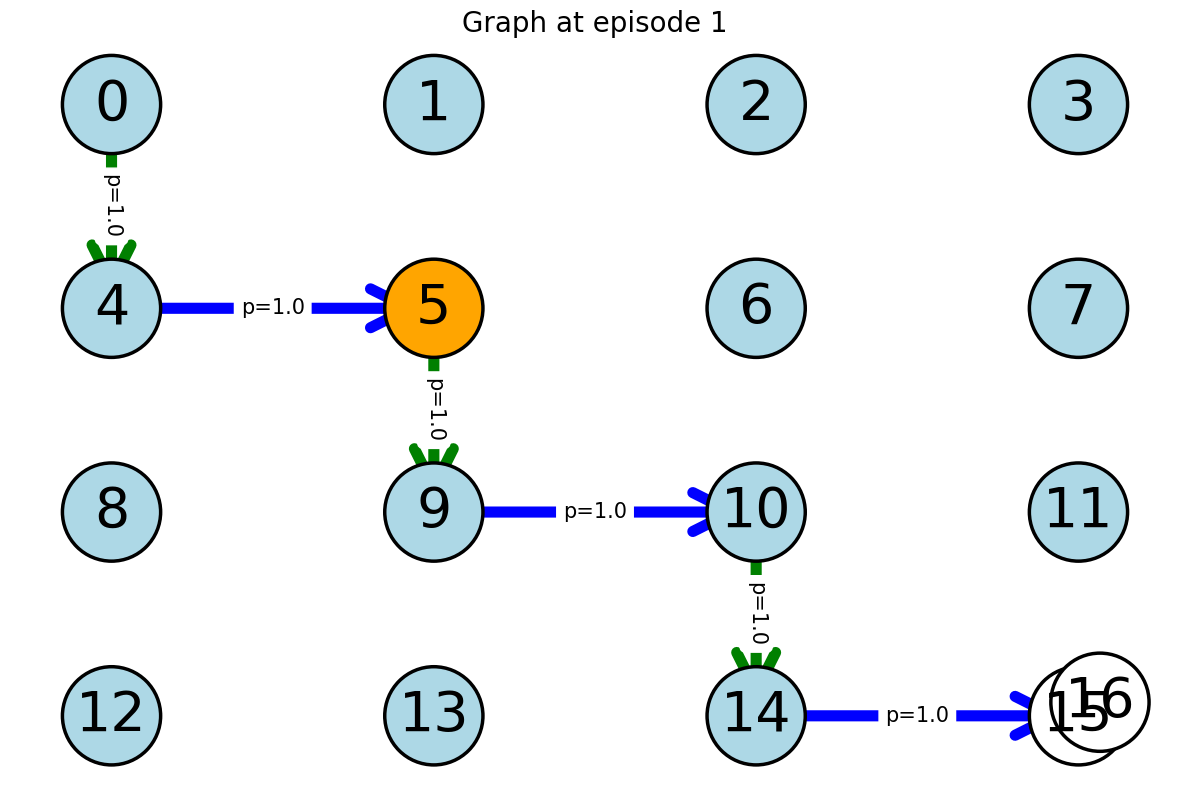

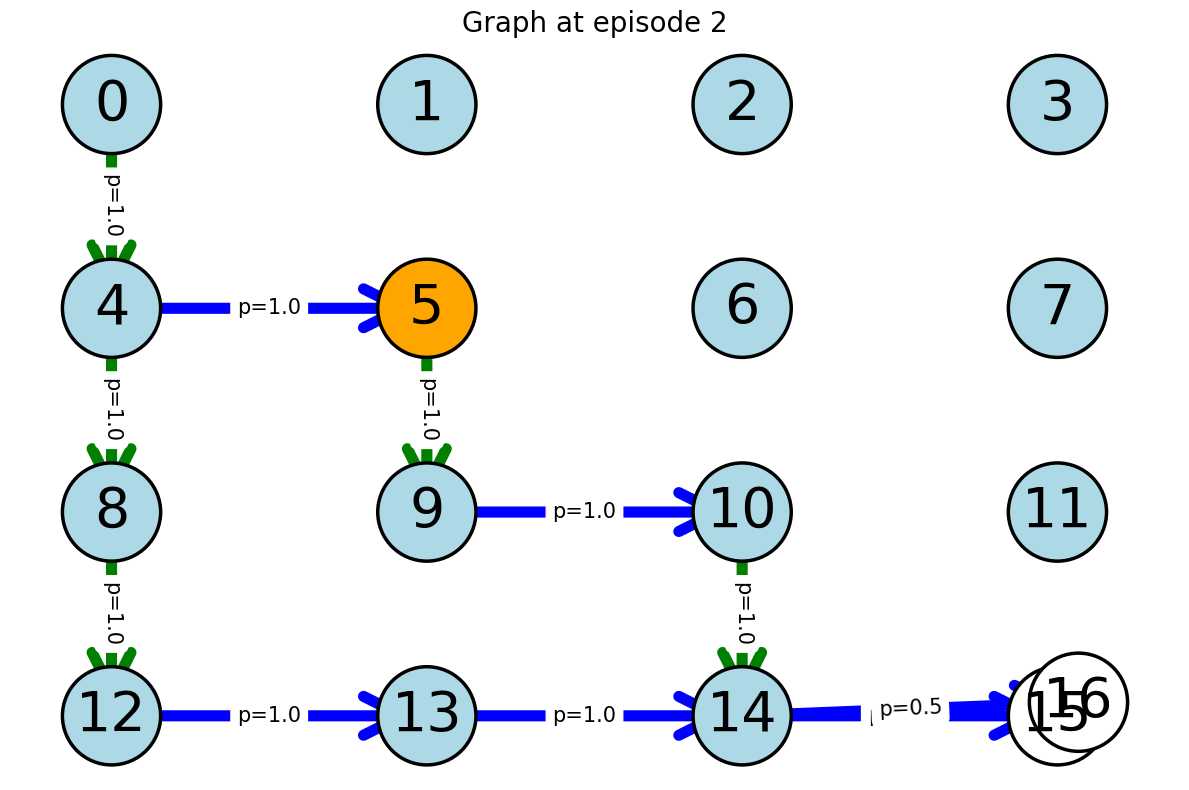

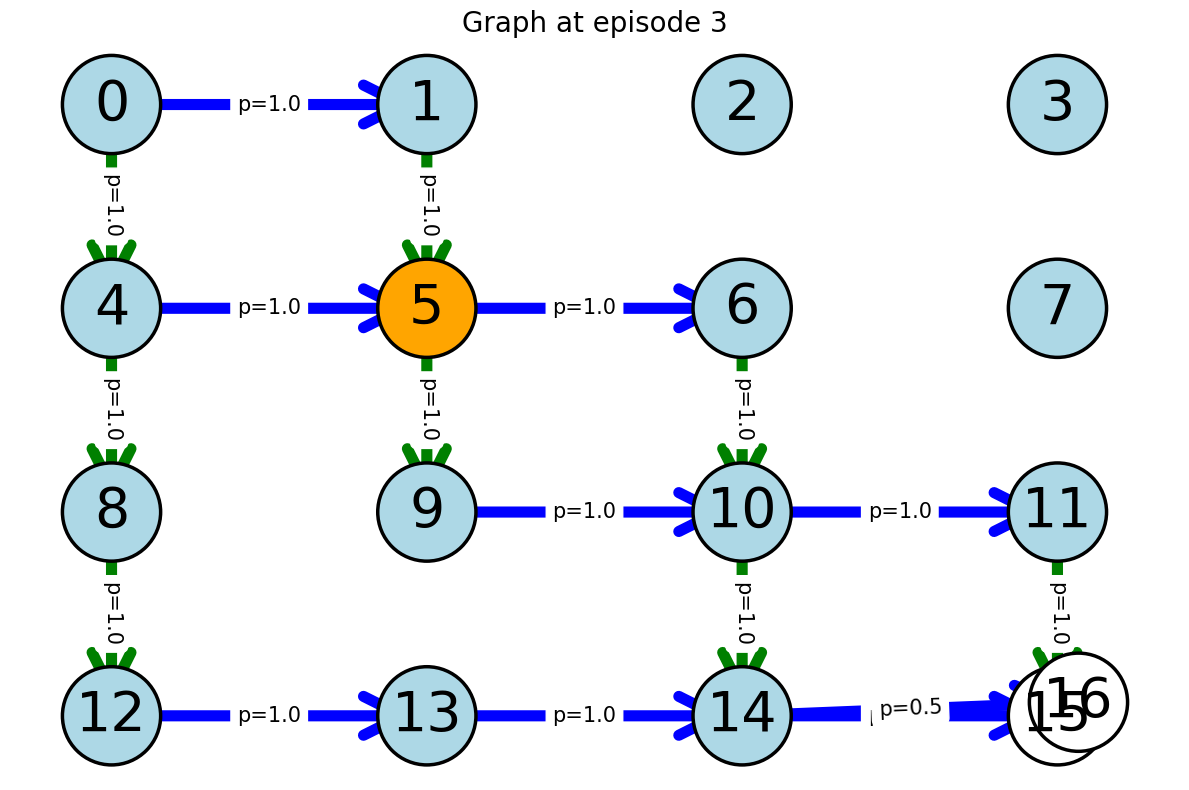

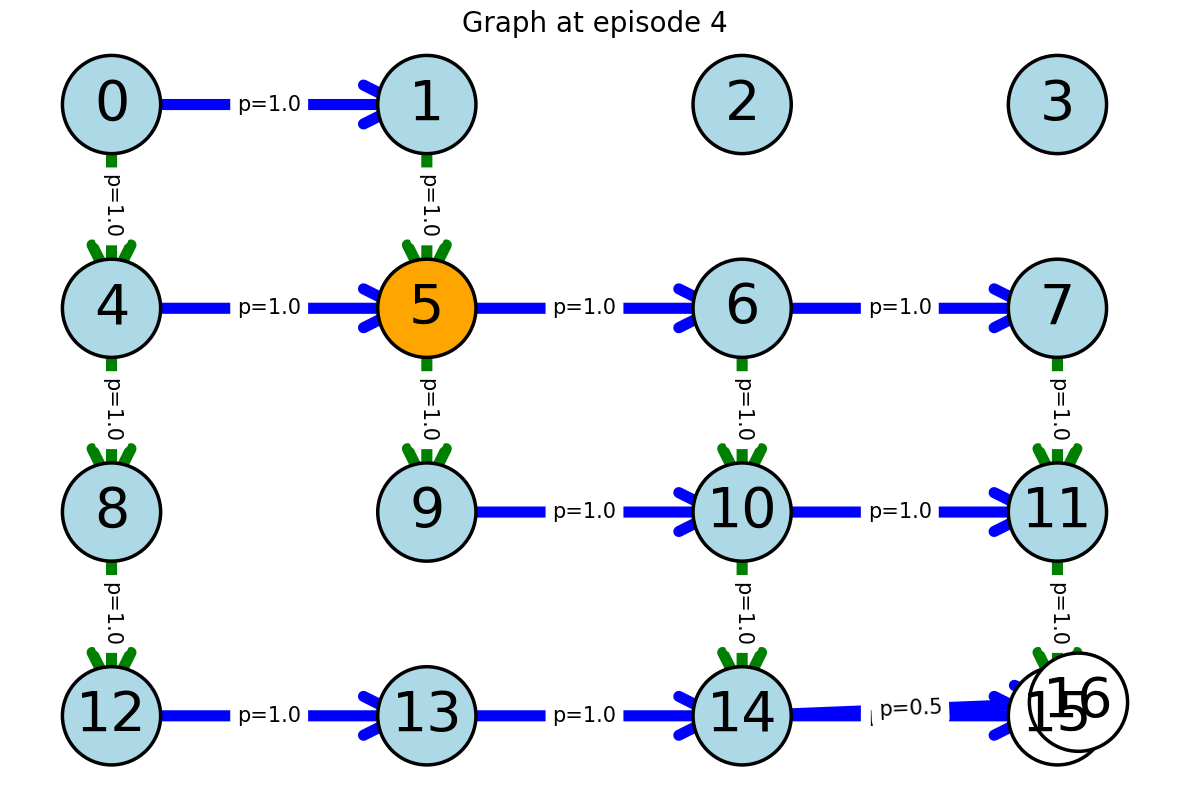

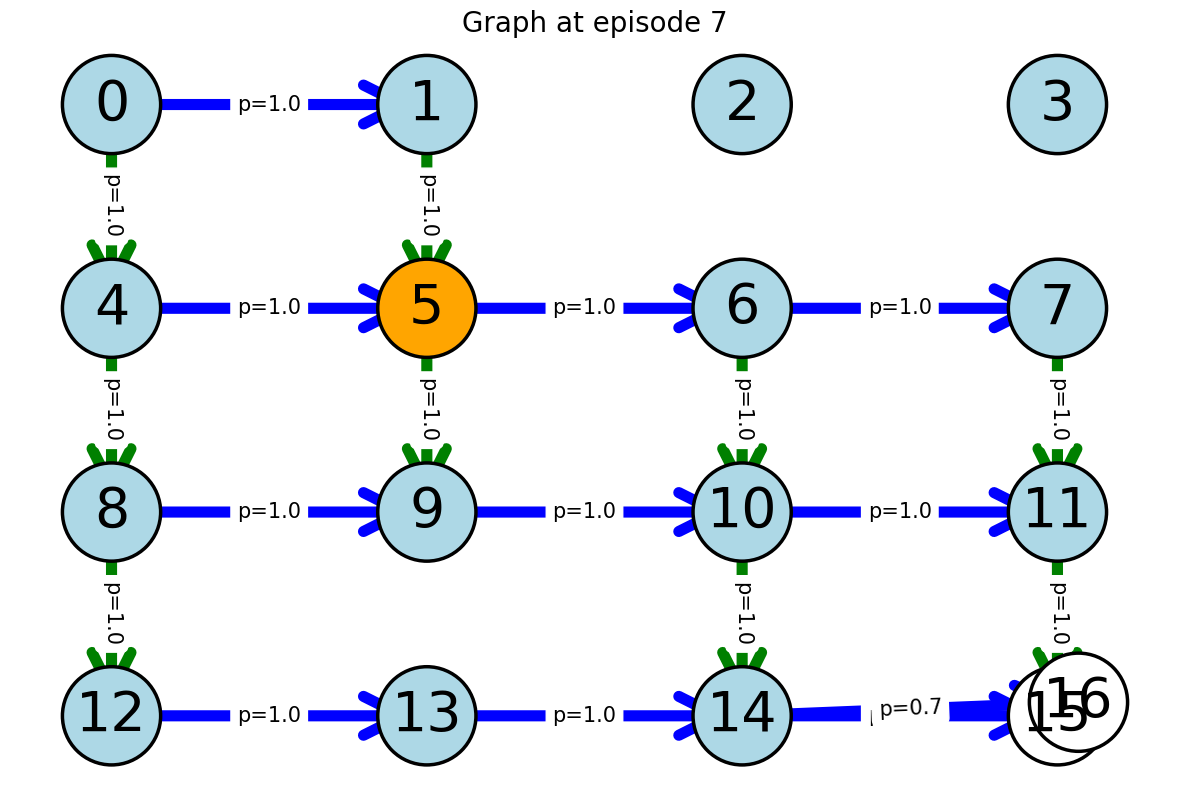

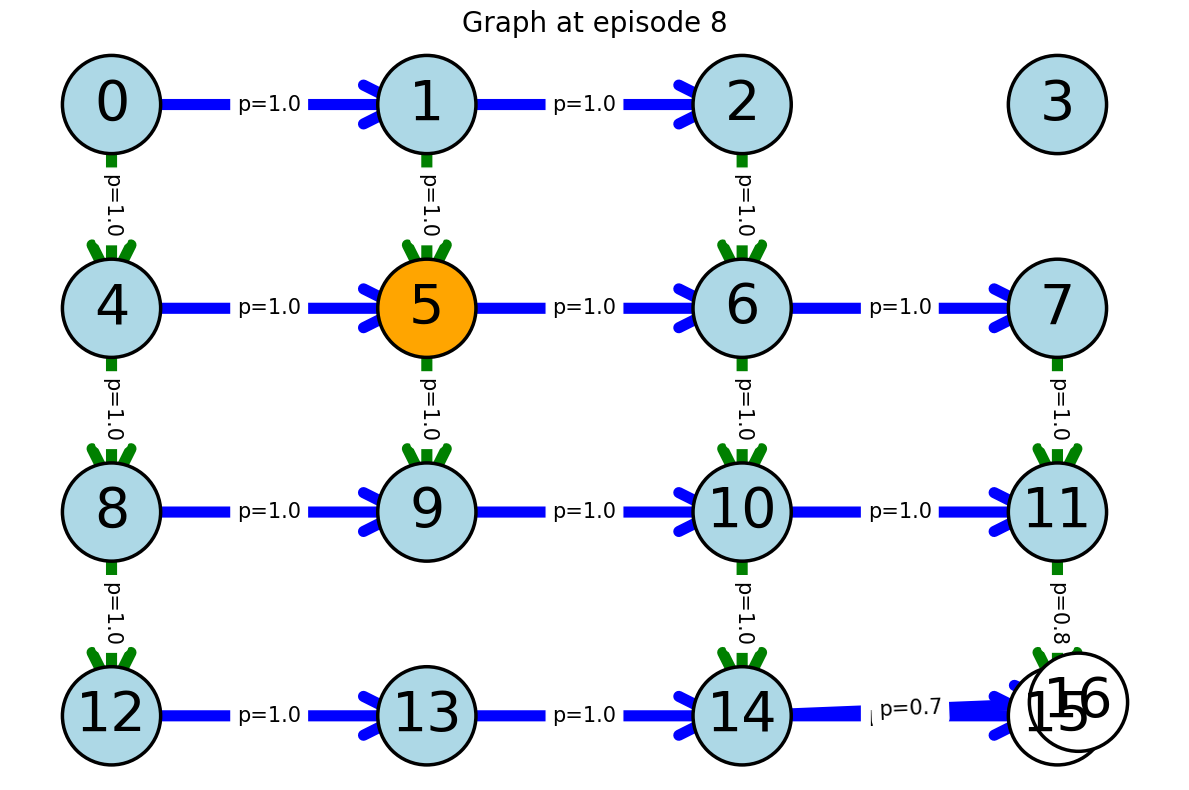

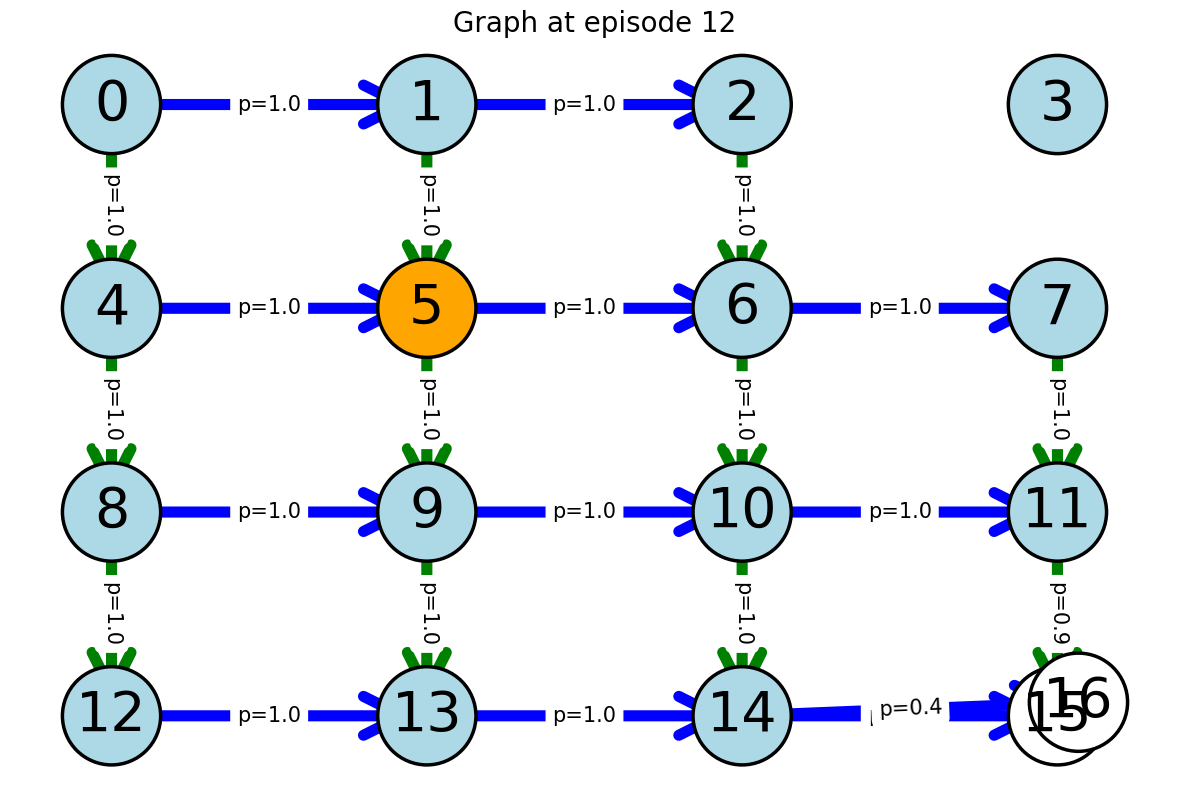

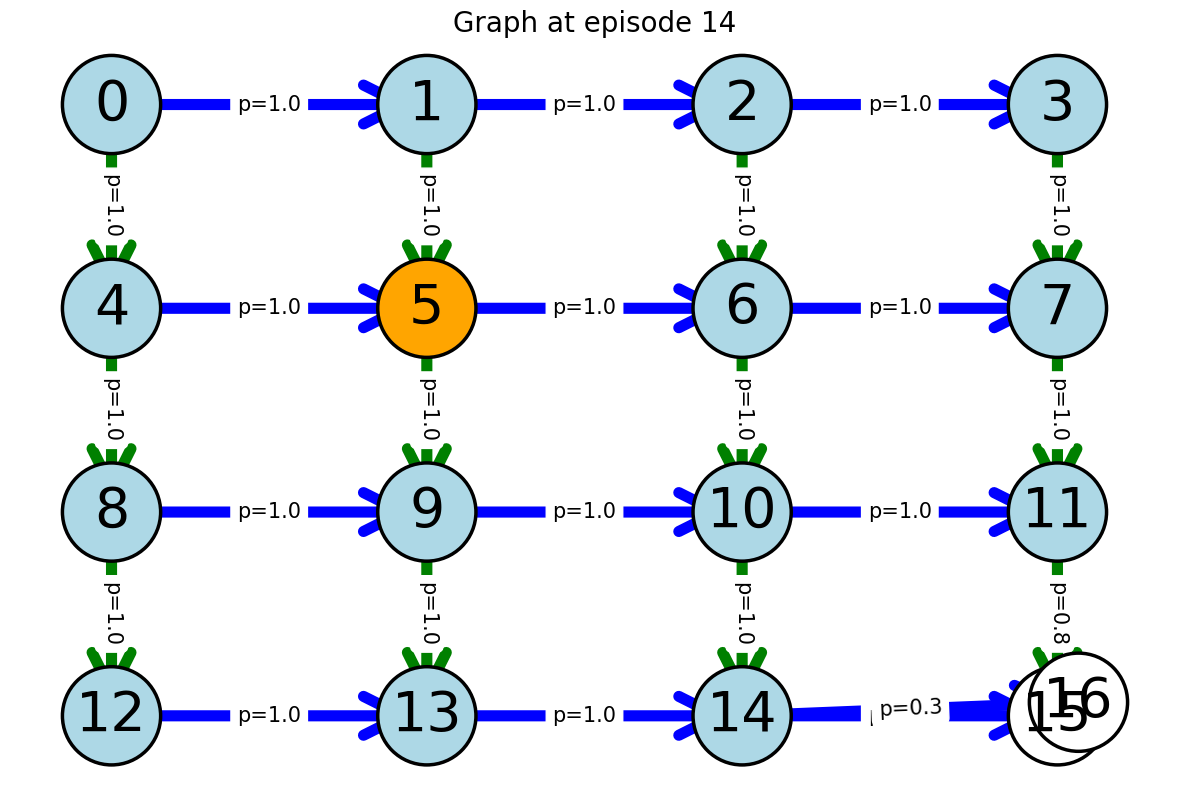

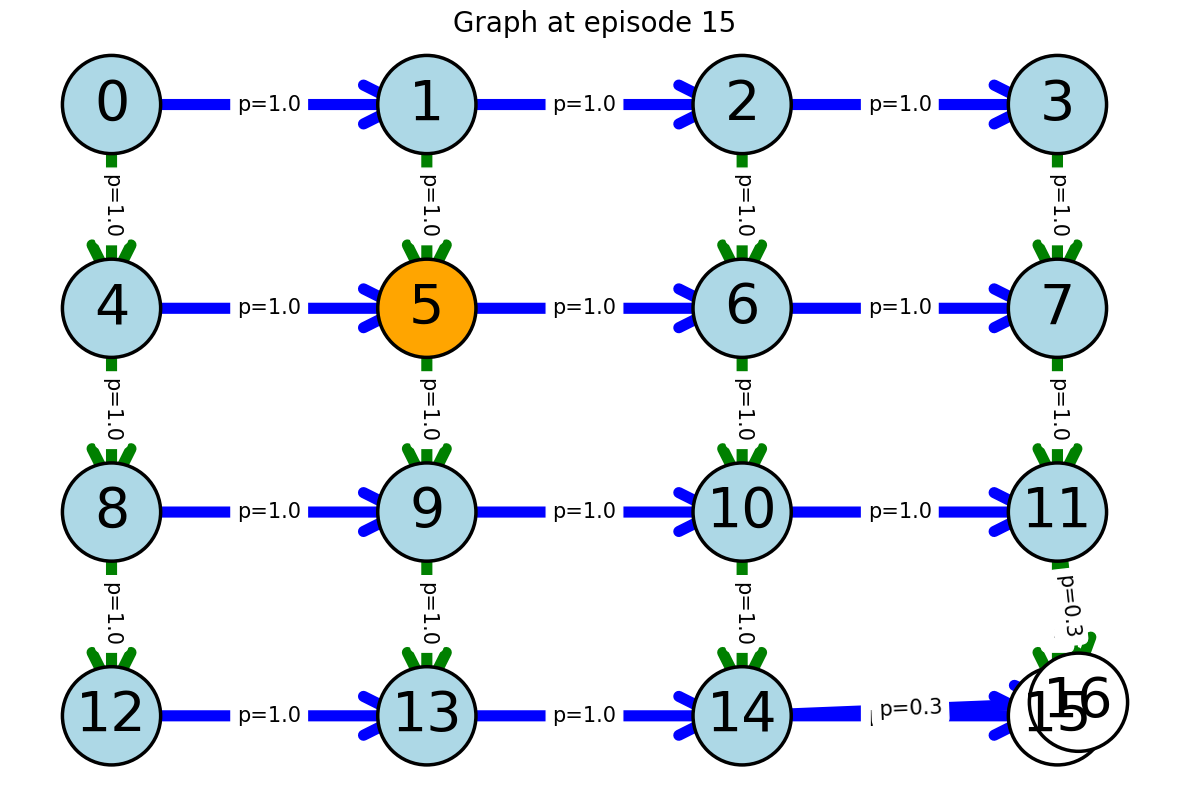

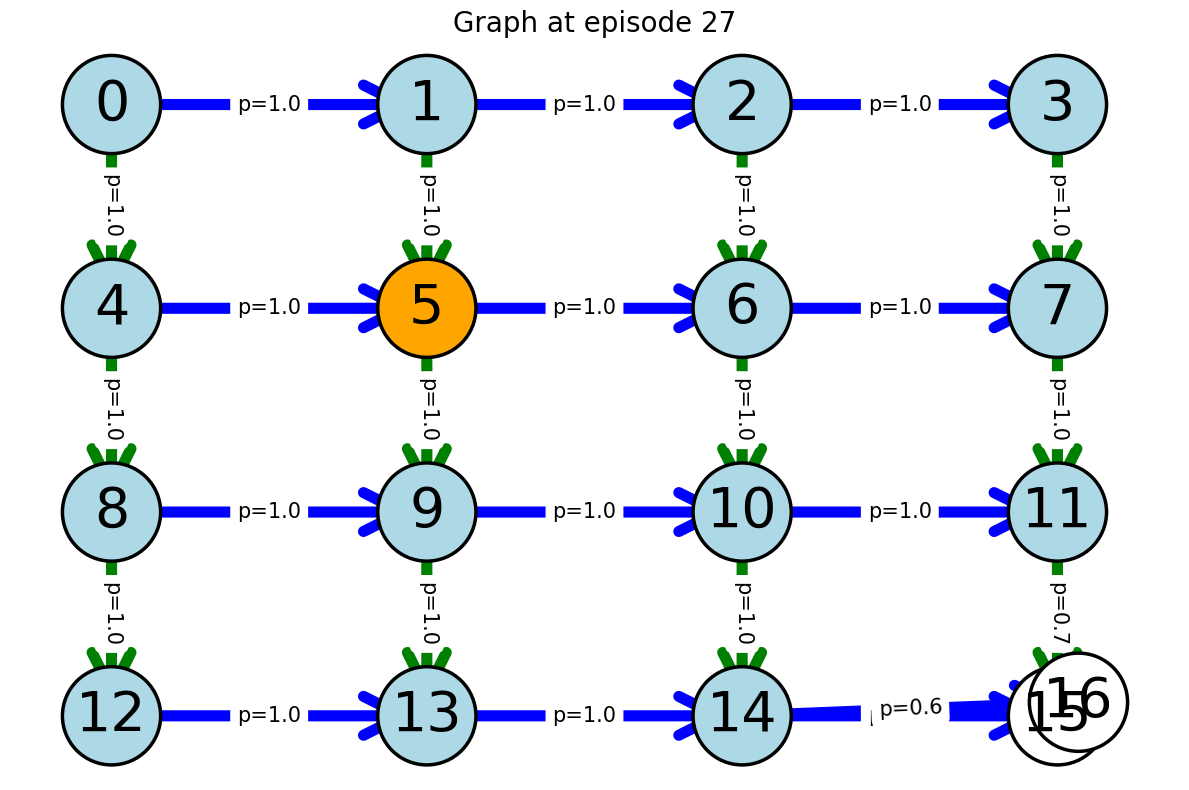

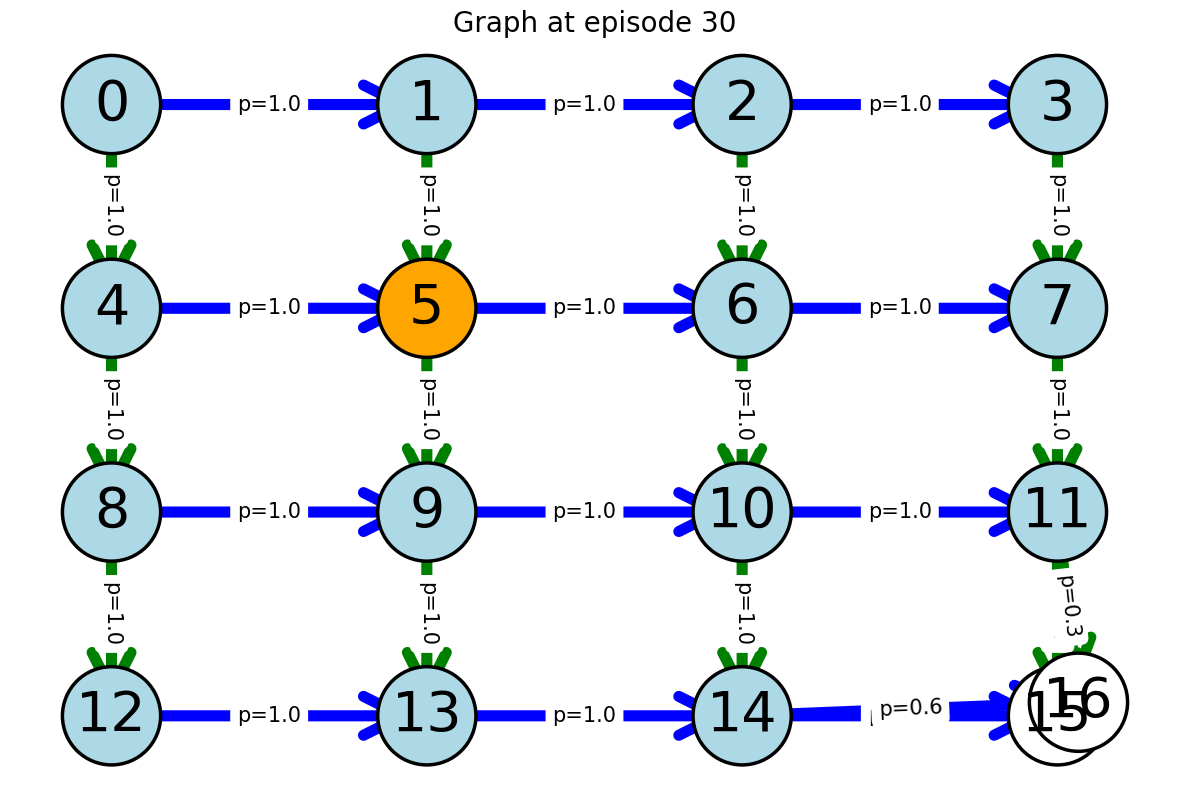

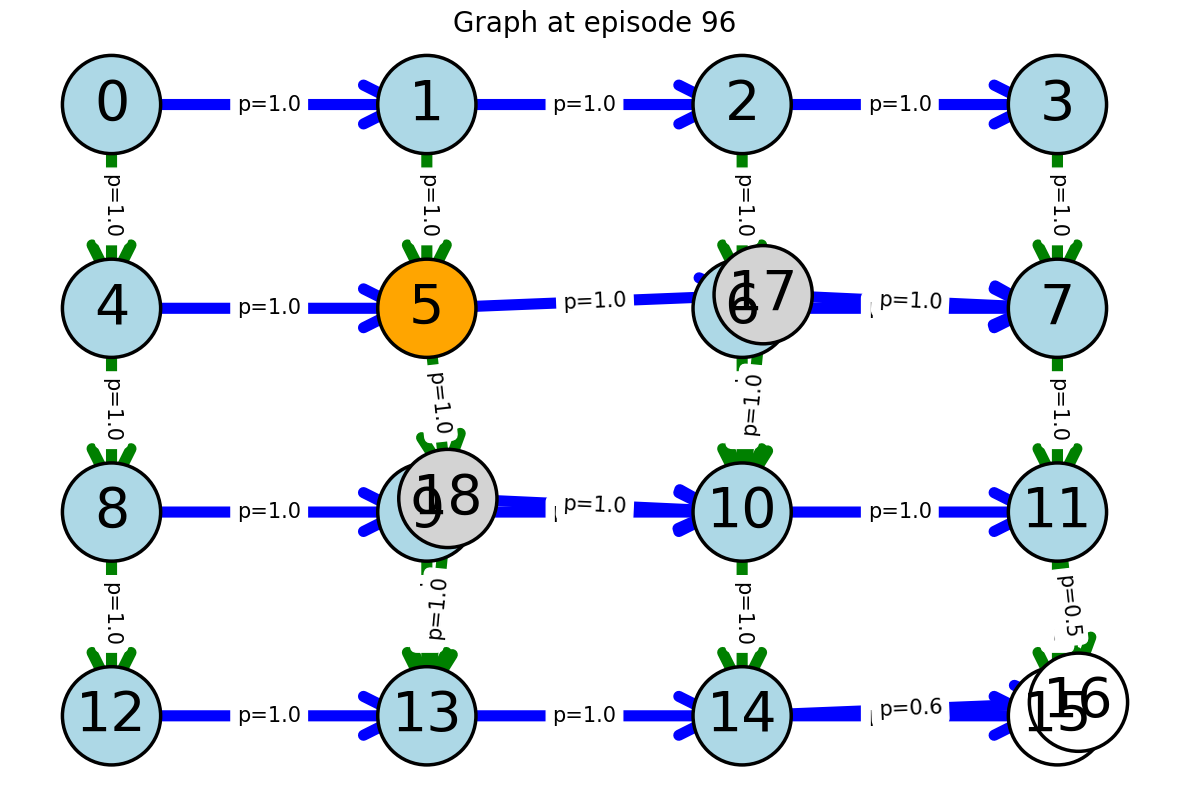

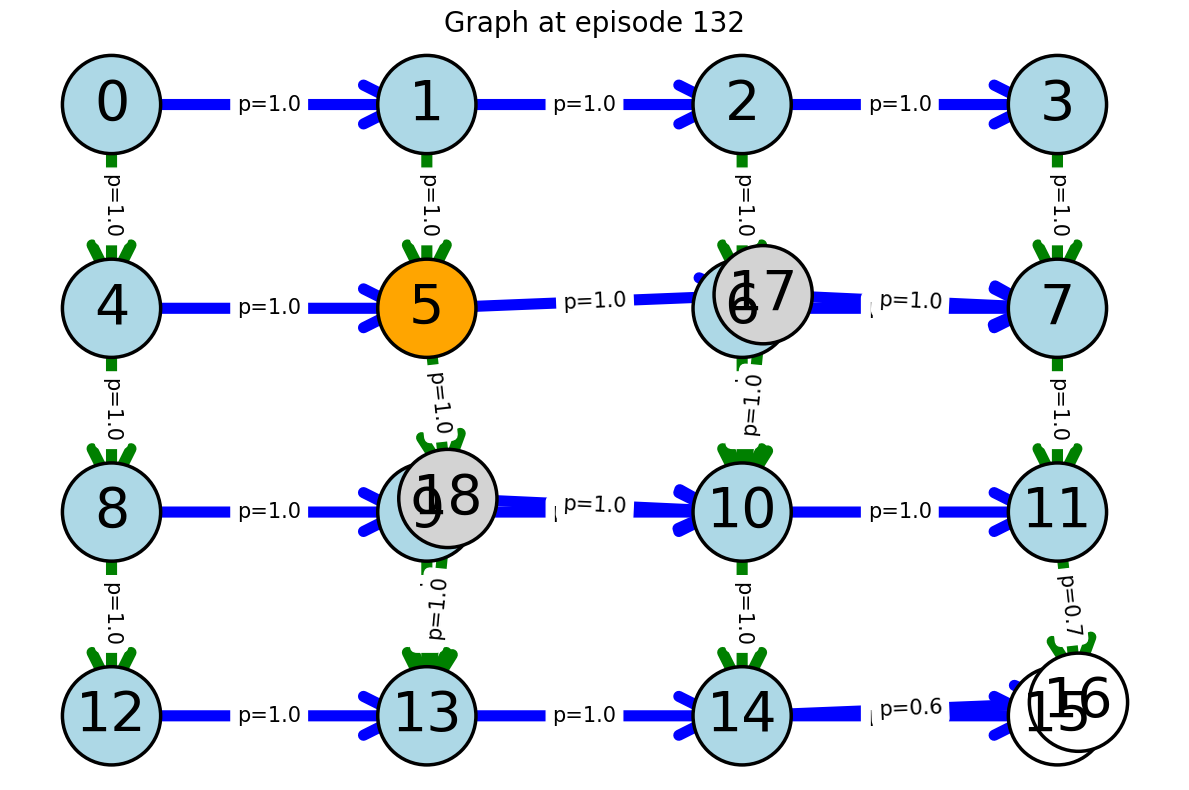

Saved acquisition frames: [1, 2, 3, 4, 7, 8, 12, 14, 15, 27, 30, 96, 132]


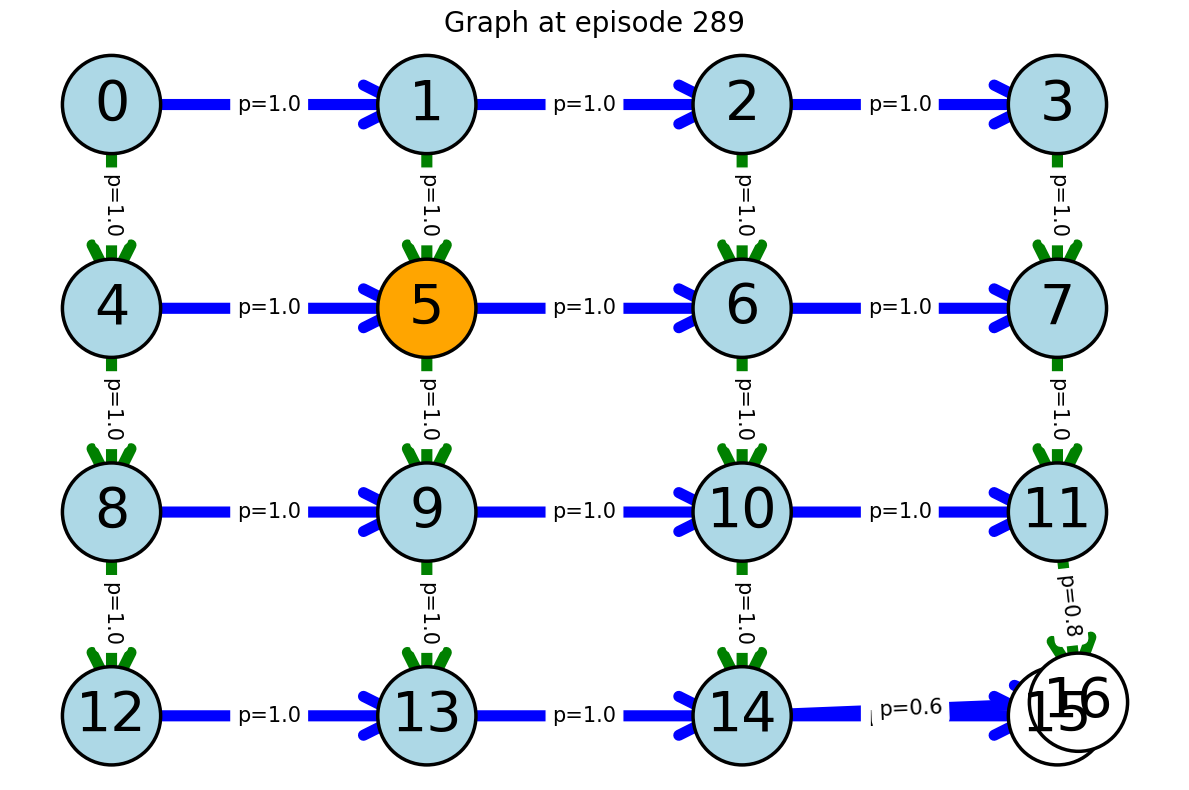

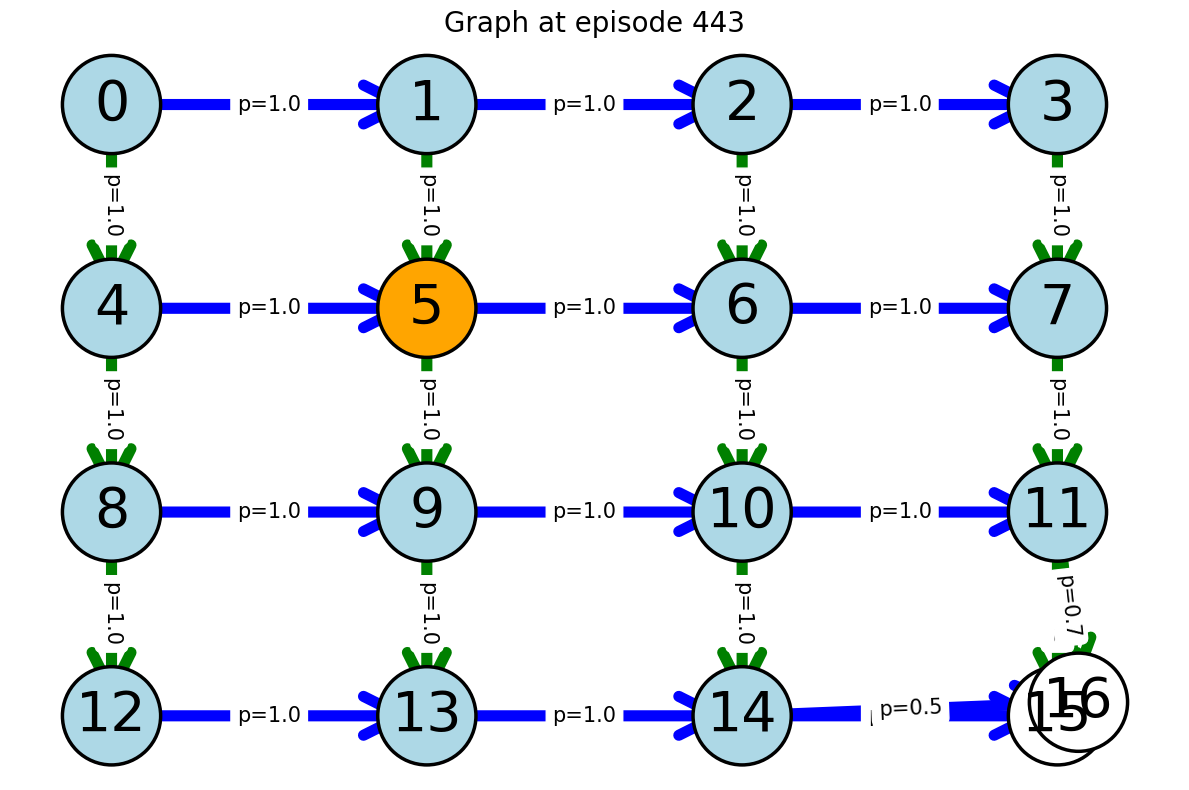

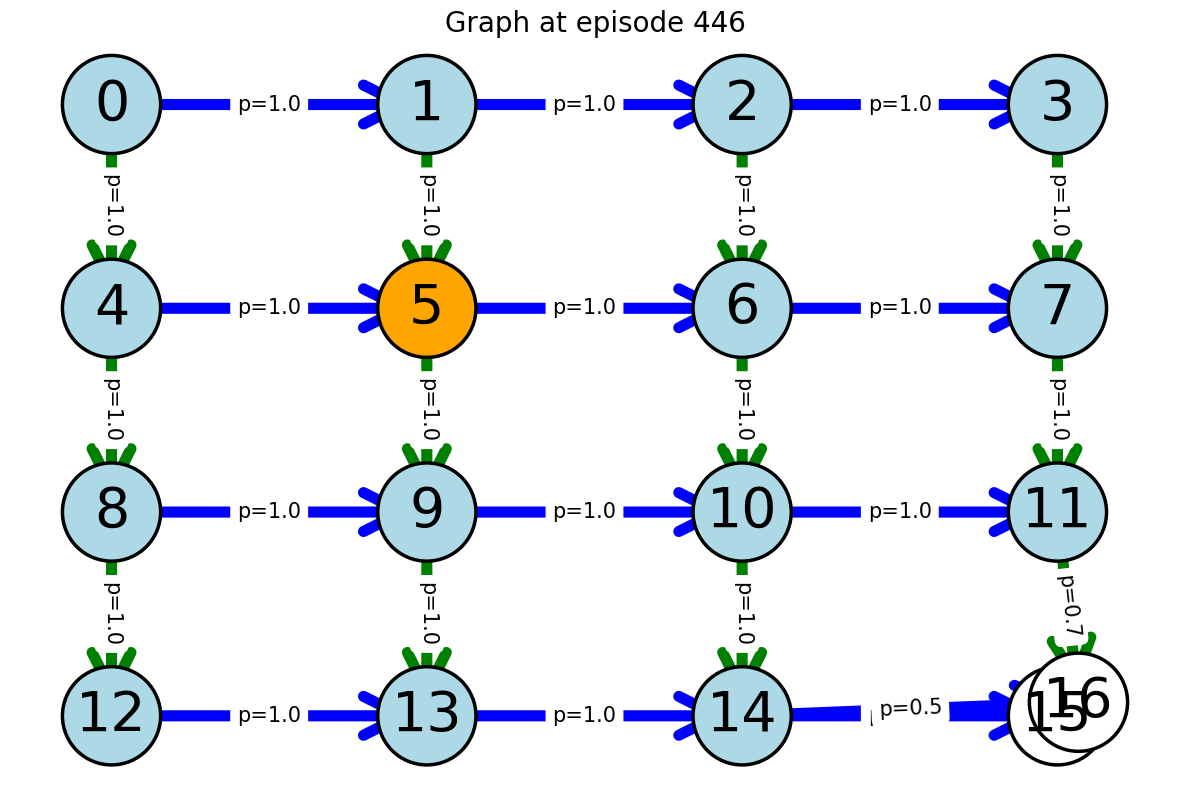

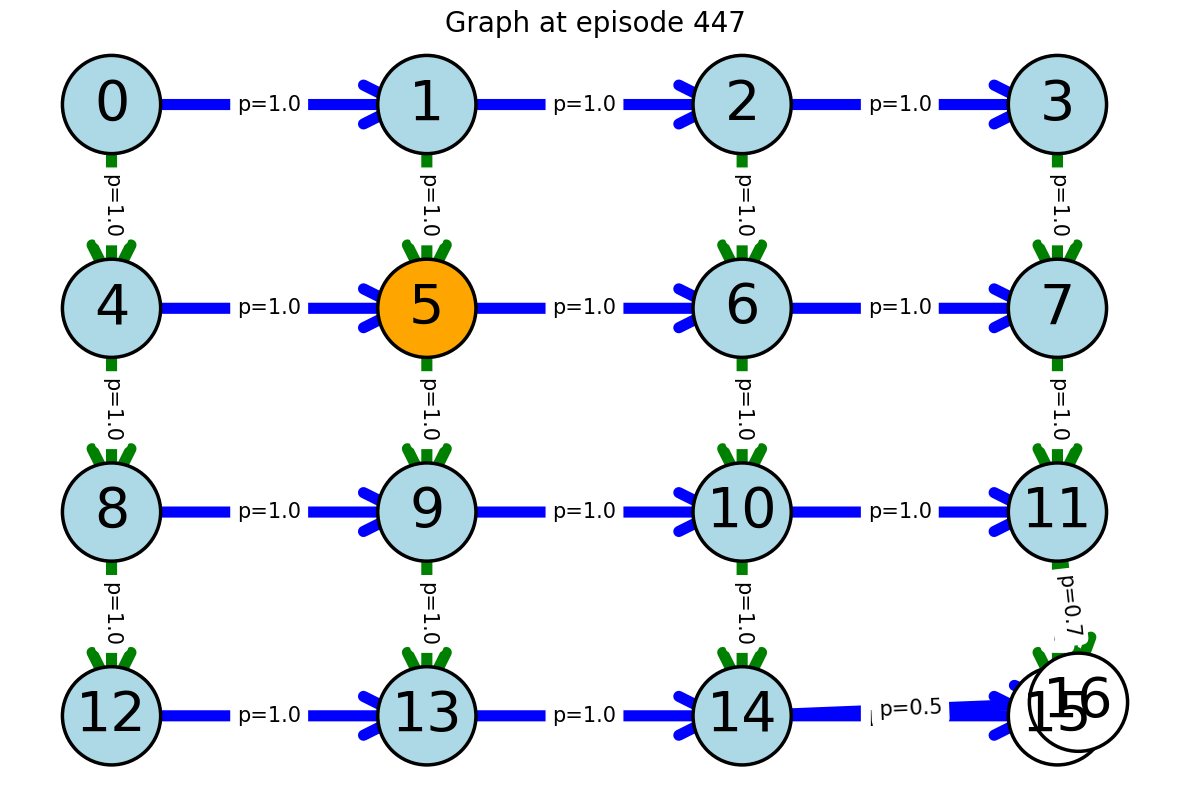

Saved extinction frames: [289, 443, 446, 447]


In [8]:

THRESH=0.30
def thresh_adj(T, thr=THRESH): A=T.sum(axis=1); return (A>=thr).astype(np.uint8)
def clone_dict_tuple(d): return tuple(sorted(d.items())) if isinstance(d,dict) else tuple()
def graph_changed(prev_T, prev_map, curr_T, curr_map, thr=THRESH):
    if curr_T is None: return False
    if prev_T is None: return True
    if prev_T.shape != curr_T.shape: return True
    A_prev, A_curr = thresh_adj(prev_T, thr), thresh_adj(curr_T, thr)
    if A_prev.shape != A_curr.shape: return True
    if (A_prev != A_curr).any(): return True
    return prev_map != curr_map

np.random.seed(PLOT_SEED)
envS = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
agentS = CoDAAgent(envS, cfg)

changed_acq=[]; prev_T=None; prev_map=None; with_clones=False; first_split=False
for ep in range(1, N_ACQ+1):
    if first_split:
        states, actions = run_episode_with_policy(envS, greedy_right_down_policy, max_steps=MAX_STEPS)
    else:
        (states, actions) = (generate_dataset_post_augmentation(envS, agentS.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0] if with_clones
                             else generate_dataset(envS, n_episodes=1, max_steps=MAX_STEPS)[0])
    agentS.update_with_episode(states, actions); absorb_terminals_in_learner(agentS)
    if agentS.maybe_split(): with_clones=True; first_split=True
    T_curr=agentS.get_T().copy(); map_curr=clone_dict_tuple(getattr(envS,"clone_dict",{}))
    if graph_changed(prev_T, prev_map, T_curr, map_curr):
        Tv=make_terminals_absorbing_for_plot(T_curr, envS.rewarded_terminals+envS.unrewarded_terminals)
        sanitize_for_plot(envS, Tv); envS.plot_graph(Tv, niter=ep, threshold=THRESH, save=True, savename=f"acq_seed{PLOT_SEED}_ep{ep}.png")
        changed_acq.append(ep); prev_T, prev_map=T_curr, map_curr
print("Saved acquisition frames:", changed_acq)

env2S = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
env2S.clone_dict=dict(getattr(envS,"clone_dict",{})); env2S.reverse_clone_dict=dict(getattr(envS,"reverse_clone_dict",{})); agentS.env=env2S
orig=dict(count_decay=agentS.cfg.count_decay, trace_decay=agentS.cfg.trace_decay, retro_decay=agentS.cfg.retro_decay,
          theta_merge=agentS.cfg.theta_merge, confidence=agentS.cfg.confidence,
          min_presence_episodes=agentS.cfg.min_presence_episodes, min_effective_exposure=agentS.cfg.min_effective_exposure)
agentS.cfg.count_decay=0.98; agentS.cfg.trace_decay=0.98; agentS.cfg.retro_decay=0.98
agentS.cfg.theta_merge=0.60; agentS.cfg.confidence=0.99
agentS.cfg.min_presence_episodes += 3; agentS.cfg.min_effective_exposure=int(agentS.cfg.min_effective_exposure*1.5)

changed_ext=[]; prev_T=prev_T; prev_map=prev_map
for k, ep in enumerate(range(N_ACQ+1, N_ACQ+N_EXT+1)):
    (states, actions) = generate_dataset_post_augmentation(env2S, agentS.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    agentS.update_with_episode(states, actions); agentS._edge_eps_override = EDGE_EPS_EARLY if k<WASH_IN else EDGE_EPS_LATE
    agentS.maybe_merge()
    T_curr=agentS.get_T().copy(); map_curr=clone_dict_tuple(getattr(env2S,"clone_dict",{}))
    if graph_changed(prev_T, prev_map, T_curr, map_curr):
        Tv=make_terminals_absorbing_for_plot(T_curr, env2S.rewarded_terminals+env2S.unrewarded_terminals)
        sanitize_for_plot(env2S, Tv); env2S.plot_graph(Tv, niter=ep, threshold=THRESH, save=True, savename=f"ext_seed{PLOT_SEED}_ep{ep}.png")
        changed_ext.append(ep); prev_T, prev_map=T_curr, map_curr
    if k==WASH_IN-1:
        agentS.cfg.count_decay=orig["count_decay"]; agentS.cfg.trace_decay=orig["trace_decay"]; agentS.cfg.retro_decay=orig["retro_decay"]
        agentS.cfg.theta_merge=orig["theta_merge"]; agentS.cfg.confidence=orig["confidence"]
        agentS.cfg.min_presence_episodes=orig["min_presence_episodes"]; agentS.cfg.min_effective_exposure=orig["min_effective_exposure"]
print("Saved extinction frames:", changed_ext)
